In [65]:
import altair as alt


def make_bars_chart(df, title, scale_title=None, avg_col='avg', sqrt_scale=True,
                   width=50, height=300, multi_bar=True, legend=True, labels=True):
    source = df.copy()

    if source[avg_col].max() > 1:
        avg_scale = 'secs'
        avg_coef = 1
    elif source[avg_col].max() > 0.001:
        avg_scale = 'ms'
        avg_coef = 1e3
    else:
        avg_scale = 'µs'
        avg_coef = 1e6

    source[avg_scale] = (df[avg_col] * avg_coef).round(2)
    
    if not scale_title:
        scale_titles = {
            'secs': 'seconds',
            'ms': 'milliseconds (1e−3 secs)',
            'µs': 'microseconds (1e−6 secs)',
        }
        scale_title = scale_titles[avg_scale]

    if sqrt_scale:
        y_scale = alt.Scale(type='sqrt')
    else:
        y_scale = alt.Scale()
    
    if multi_bar:
        x_val = 'bench:N'
        facet_kwds = {'column':'name:N'}
    else:
        x_val = 'name:N'
        facet_kwds = {}

    if legend:
        legend = alt.Legend()
    else:
        legend = None

    chart = alt.Chart(
        width=width,
        height=height,
    ).mark_bar(
        stroke='transparent',
        size=20,
    ).encode(
        alt.X(x_val, scale=alt.Scale(), axis=alt.Axis(title='', labels=labels)),
        alt.Y(f'{avg_scale}:Q', scale=y_scale, axis=alt.Axis(title=scale_title, grid=False)),
        color=alt.Color(x_val, scale=alt.Scale(range=["#FF7B06", "#094AFB", "#D60000"]), legend=legend),
    )

    text = chart.mark_text(
        color='black',
        dx = 0,
        dy = -2,
    ).encode(
        text=f'{avg_scale}:Q'
    )

    return alt.layer(chart, text, data=source).facet(
        **facet_kwds
    ).configure_axis(
        domainWidth=0.8,
    ).configure_view(
        stroke='transparent'
    ).properties(
        title=title
    )

In [66]:
import pandas as pd
single_df = pd.read_json('results.json', orient='records')
single_df.head()

,bench,iter,ok,took,tool
0,9digits,0,True,5.813536,cracken
1,9digits,0,True,5.801832,cracken
2,9digits,0,True,5.798843,cracken
3,9digits,0,True,5.831403,cracken
4,9digits,0,True,5.824552,cracken


In [67]:
df = single_df.groupby(['bench', 'tool']).mean().reset_index()
df['tool'].replace('crunch', ' crunch', inplace=True)
df

,bench,tool,iter,ok,took
0,1-8digits,cracken,0,True,0.673989
1,1-8digits,crunch,0,False,NaN
2,1-8digits,maskprocessor,0,True,0.824871
3,9digits,cracken,0,True,5.849939
4,9digits,crunch,0,True,196.409606
5,9digits,maskprocessor,0,True,7.215527
6,upper-5lower-digit,cracken,0,True,18.159238
7,upper-5lower-digit,crunch,0,True,517.496733
8,upper-5lower-digit,maskprocessor,0,True,22.529463


In [68]:
df['secs'] = df['took']
df['name'] = df['tool']
df['ms'] = df['took'] * 1000.0
df['µs'] = df['took'] * 1_000_000.0
df

,bench,tool,iter,ok,took,secs,name,ms,µs
0,1-8digits,cracken,0,True,0.673989,0.673989,cracken,673.989079,6.739891e+05
1,1-8digits,crunch,0,False,NaN,NaN,crunch,NaN,NaN
2,1-8digits,maskprocessor,0,True,0.824871,0.824871,maskprocessor,824.870810,8.248708e+05
3,9digits,cracken,0,True,5.849939,5.849939,cracken,5849.938711,5.849939e+06
4,9digits,crunch,0,True,196.409606,196.409606,crunch,196409.605503,1.964096e+08
5,9digits,maskprocessor,0,True,7.215527,7.215527,maskprocessor,7215.527268,7.215527e+06
6,upper-5lower-digit,cracken,0,True,18.159238,18.159238,cracken,18159.238407,1.815924e+07
7,upper-5lower-digit,crunch,0,True,517.496733,517.496733,crunch,517496.733189,5.174967e+08
8,upper-5lower-digit,maskprocessor,0,True,22.529463,22.529463,maskprocessor,22529.462934,2.252946e+07


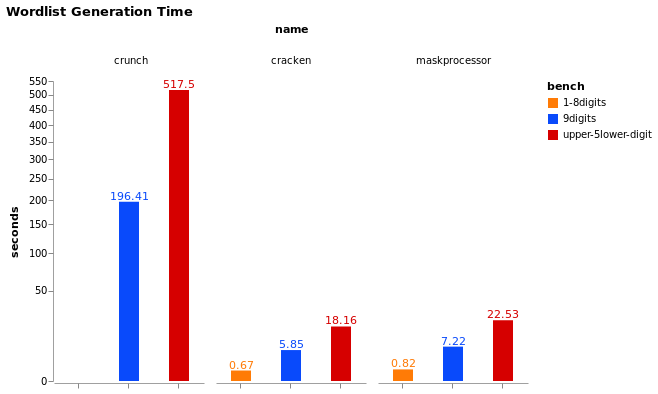

In [75]:
make_bars_chart(
    df,
    title='Wordlist Generation Time',
    sqrt_scale=True,
    labels=False,
    avg_col='took',
    width=150,
    height=300,
)

In [70]:
min_took_df = df[df['tool'] == 'cracken'][['bench', 'took']].groupby('bench').min().reset_index()
min_took = {x.bench: x.took for x in min_took_df.itertuples()}
min_took

{'1-8digits': 0.6739890788520514,
 '9digits': 5.849938710530599,
 'upper-5lower-digit': 18.159238406590053}

In [71]:
df['speedup'] = df.apply(lambda x: x.took / min_took[x.bench], axis=1)

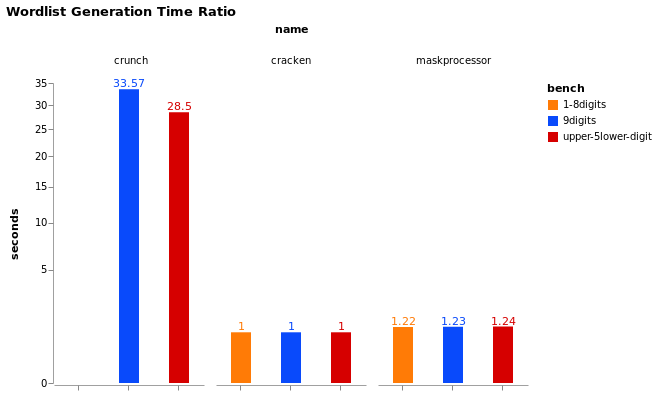

In [76]:
make_bars_chart(
    df,
    title='Wordlist Generation Time Ratio',
    sqrt_scale=True,
    labels=False,
    avg_col='speedup',
    width=150,
    height=300,
)